In [1]:
import pandas as pd
import numpy as np

import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_pickle("../data/df_filtered_cnn.pkl")

df.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
timestamp,,,,,,,
1970-01-01 00:38:38.700,0.209754,-2.331582,-0.203113,0.037081,0.031012,-0.012518,BSC
1970-01-01 00:38:38.800,0.203321,-2.349069,-0.194536,0.066225,0.079630,0.009396,BSC
1970-01-01 00:38:38.900,0.249716,-2.355785,-0.211275,0.196319,0.130287,0.033033,BSC
1970-01-01 00:38:39.000,0.276253,-2.345908,-0.201750,0.452604,0.035785,0.063763,BSC
1970-01-01 00:38:39.100,0.229522,-2.311028,-0.161954,0.682246,0.042157,0.127645,BSC


In [3]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(data, window_size=25, step_size=12):
    X, y = [], []
    data_array = data[sensor_cols].values
    labels = data['label'].values

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window_data = data_array[start:end]
        window_labels = labels[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X.append(window_data)
        y.append(label)

    return np.array(X), np.array(y)

X, y = create_windows(df)

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, Attention
from tensorflow.keras.optimizers import Adam

# Assuming you've already defined your training data arrays (X_train, y_train)
# For example:
# X_train.shape => (num_samples, window_length, num_channels)
# Let num_classes be the total number of classes (e.g., fall types and ADLs)
input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (25, 6)
num_classes = len(set(y_train))  # e.g., 16 if you have 16 labels

# Define the input layer
inputs = Input(shape=input_shape)

# Convolutional Feature Extraction Layers
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

# Self-Attention Mechanism: Using the same tensor as queries and keys/values (self-attention)
attn_output = Attention()([x, x])
# The attention layer allows the model to recalibrate its focus across the entire window

# Global Pooling: Converts the feature map into a flat vector
x = GlobalAveragePooling1D()(attn_output)

# Dense layers for further processing and classification
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model
model_attention = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_attention.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Display the model architecture
model_attention.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 25, 64)    │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 25, 128)   │     24,704 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 12, 128)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 128)   │     49,280 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 12, 128)   │          0 │ conv1d_3[0][0],   │
│ (Attention)         │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,496 (330.06 KB)

 Trainable params: 84,496 (330.06 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model_attention.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7448 - loss: 0.8455 - val_accuracy: 0.8949 - val_loss: 0.2895
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8871 - loss: 0.3185 - val_accuracy: 0.9131 - val_loss: 0.2313
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8996 - loss: 0.2752 - val_accuracy: 0.9266 - val_loss: 0.2012
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9162 - loss: 0.2229 - val_accuracy: 0.9297 - val_loss: 0.1958
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9191 - loss: 0.2099 - val_accuracy: 0.9319 - val_loss: 0.1729
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9263 - loss: 0.1882 - val_accuracy: 0.9365 - val_loss: 0.1734
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9290 - loss: 0.1806 - val_accuracy: 0.9383 - val_loss: 0.1640
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9311 - loss: 0.1679 - 

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9577 - loss: 0.1018 - val_accuracy: 0.9541 - val_loss: 0.1493


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1493
Test Accuracy: 0.9541
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


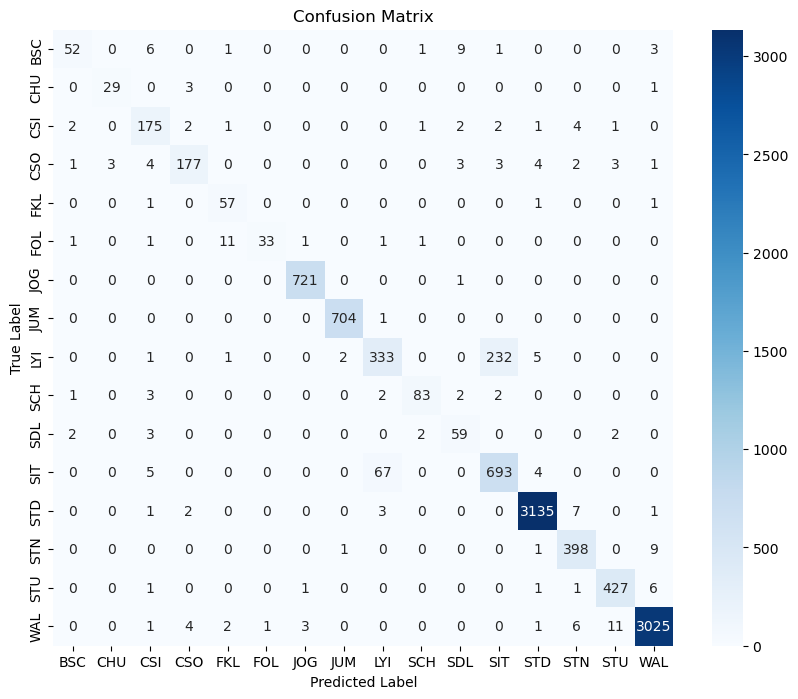

Classification Report:
               precision    recall  f1-score   support

         BSC       0.88      0.71      0.79        73
         CHU       0.91      0.88      0.89        33
         CSI       0.87      0.92      0.89       191
         CSO       0.94      0.88      0.91       201
         FKL       0.78      0.95      0.86        60
         FOL       0.97      0.67      0.80        49
         JOG       0.99      1.00      1.00       722
         JUM       1.00      1.00      1.00       705
         LYI       0.82      0.58      0.68       574
         SCH       0.94      0.89      0.92        93
         SDL       0.78      0.87      0.82        68
         SIT       0.74      0.90      0.81       769
         STD       0.99      1.00      0.99      3149
         STN       0.95      0.97      0.96       409
         STU       0.96      0.98      0.97       437
         WAL       0.99      0.99      0.99      3054

    accuracy                           0.95     10587
  

In [14]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model_attention, X_test, y_test, label_classes=label_classes)
